# Period of infectivity and herd immunity

Goals for today:

1. Make it so that nodes only stay infected for a limited time
1. Add vaccination (herd immunity)
1. Brainstorm "Proper modeling", and what it means for this model
1. Perform one good proper analysis of any 2 parameters (in this case: transmission probability and period of infection)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A graph of 3 nodes:
0:[1]
1:[0]
2:[]

Nodes: [0, 1, 2]
Edges: [(0, 1)]


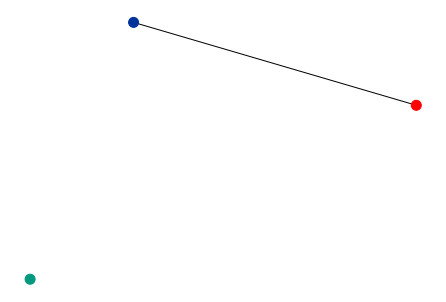

In [5]:
class Graph():
    def __init__(self):
        self.gdict = {}
        self.values = {}    # 0 for healthy, 1 for infected
        
    def add_node(self, node, val=None):
        """If node is not in a dictionary, add it."""
        if node not in self.gdict:
            self.gdict[node] = []
        self.values[node] = val
    
    def add_edge(self, node1, node2):        
        self.add_node(node1)
        self.add_node(node2)
        # Add node2 as a connection for node1, and the other way around
        if node2 not in self.gdict[node1]:
            self.gdict[node1].append(node2)
        if node1 not in self.gdict[node2]:
            self.gdict[node2].append(node1)
            
    def delete_edge(self, node1, node2):
        if node1 not in self.gdict[node2]: return # This edge doesn't exist, done
        self.gdict[node1].remove(node2)
        self.gdict[node2].remove(node1)
            
    def get_nodes(self):
        """Returns a list of nodes."""
        return list(self.gdict.keys())
    
    def get_edges(self):
        """Returns a list of edges."""
        out = []
        for node,links in self.gdict.items():
            for link in links:
                if node<link:
                    out.append((node,link))
        return out
            
    def __str__(self):
        out = 'A graph of ' + str(len(self.gdict)) + ' nodes:\n'
        for node in self.gdict:
            out += str(node) + ':' + str(self.gdict[node]) + '\n'
        return out
    
    def plot(self):
        RED = (1, 0, 0)
        BLUE = (0, 0.2, 0.6)
        GREEN = (0, 0.6, 0.5)
        
        g_nx = nx.Graph()
        nodes = self.get_nodes()
        g_nx.add_nodes_from(nodes)
        g_nx.add_edges_from(self.get_edges())
        colors = []
        for i in range(len(nodes)):
            if self.values[nodes[i]] is not None:
                if self.values[nodes[i]][0]=='healthy':
                    colors.append(BLUE)
                elif self.values[nodes[i]][0]=='infected':
                    colors.append(RED)
                else:
                    colors.append(GREEN)
            else:
                colors.append(BLUE)
        nx.draw_kamada_kawai(g_nx, node_size=100, node_color=colors)
        #nx.draw_spring(g_nx, node_size=100, node_color=colors)
    
# Test
g = Graph()
g.add_edge(0,1)
g.add_edge(0,2)
g.delete_edge(0,2)
print(g)
print('Nodes:',g.get_nodes())
print('Edges:',g.get_edges())
g.values[0] = ['infected', None]
g.values[2] = ['immune', None]
g.plot()

In [6]:
def degrees(g):
    """Calculates and plots the degrees distribution for a graph."""
    degrees = []
    for node,links in g.gdict.items():
        degrees.append(len(links))

    #print(degrees)
    hist = np.zeros(max(degrees)+1)
    for degree in degrees:
        hist[degree] += 1
    #print(hist)

    plt.plot(hist,'.-');
    plt.xlabel('Degrees')
    plt.ylabel('Frequency')
    
    return hist

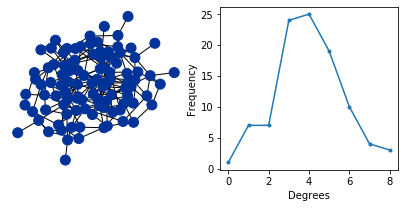

In [7]:
def random_network(n_nodes=7):
    """Creates a random (Erdos type II) network, with N(E)=N(V)."""
    n_edges = 2*n_nodes

    g = Graph()
    for i in range(n_nodes):
        g.add_node(i)
    edges = []
    while len(edges)<n_edges:
        n1 = np.random.randint(low=0, high=n_nodes)
        n2 = np.random.randint(low=0, high=n_nodes)
        if n2<n1:
            n1,n2 = n2,n1

        if (n1,n2) not in edges and n1!=n2:
            g.add_edge(n1,n2)
            edges.append((n1,n2))
    return g
    
#print(g)

g = random_network(100)
plt.figure(figsize=(7,3))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees_random = degrees(g)

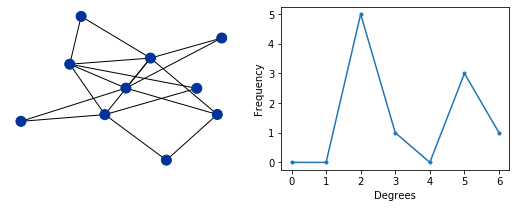

In [8]:
def barabasi(n_nodes=7):
    """Barabasi-Alberts network creator. N_edges ~ 2*N_nodes."""
    g = Graph()
    degrees = np.zeros(n_nodes)
    nodes = np.array(range(n_nodes))
    for i in range(n_nodes):
        if i==0:
            g.add_node(0)
        elif i==1:
            g.add_edge(1,0)
            degrees[0] = 1
            degrees[1] = 1
        else: # Actual preferential attachment
            connections = np.random.choice(nodes[:i], size=2, replace=False, p=degrees[:i]/np.sum(degrees))
            for node in connections:
                g.add_edge(i, node)
                degrees[node] += 1
            degrees[i] = 2
        #print(i,'Nodes:',nodes,'Degrees:',degrees)
    return g

g = barabasi(10)
plt.figure(figsize=(9,3))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees(g);

To make nodes infectious for only limited amount of time, we need to track the time that passed since they got infected.

And for now, for each node, we only keep one value that characterizes it (`g.values[]` dict).

Three ways of doing that:
1. To extend the number of states in `g.values[]` by using some fancy coding scheme, like 0 = healthy and succeptible, 1 to k stands for infectious, and k+1 means "immune". And we'd increase the value at every step, once it's above 0. Not really scaleable (if we even have to add more states for a node, we'd be in a trouble).
1. To give this class (Graph) another property, also a dictionary, to store the time since infection. In this case `g.values[]` would remain clear and clean (0=succeptible, 1=infectious, 2=immune), which is good. But the downside is that we need to mess with the Graph class.
1. To make each value of `g.values[]` to be a list, where the 0th element is that state (nice and clean), and the next (1st) element is the "time since infection" value. To address the state, we'd do `g.values[id][0]`.

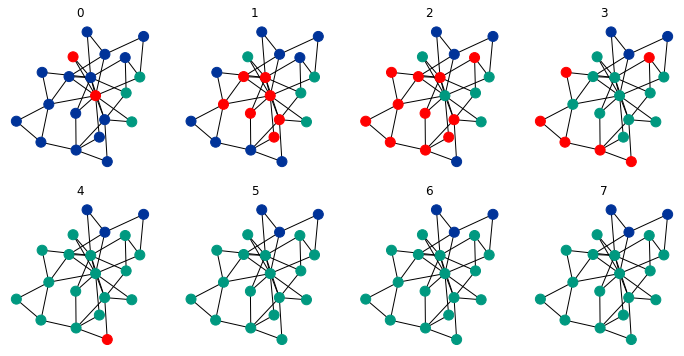

In [9]:
def pandemic(g, prob=0.5, nsteps=10, infect_period=1, vax_rate=0, reinitialize=True):
    """Runs the pandemic for several steps."""
    nodes = g.get_nodes()
    if reinitialize:
        for node in nodes:
            if np.random.uniform()<vax_rate:
                g.values[node] = ['immune', 0]       # Vaccinated
            else:
                g.values[node] = ['healthy', 0]      # Succeptible
        patient_zero = np.random.randint(low=0, high=len(nodes))
        g.values[patient_zero] = ['infected', 0]  # Only one node is sick

    history = np.zeros(nsteps)
    for t in range(nsteps):
        newly_infected = []
        is_active = False
        for node in nodes:
            if g.values[node][0] == 'infected':         # If the node is infectious
                is_active = True
                if g.values[node][1] == infect_period:
                    g.values[node][0] = 'immune'
                else:
                    g.values[node][1] += 1                  # One more day since the infection
                    neighbors = g.gdict[node]
                    for neighbor in neighbors:
                        if g.values[neighbor][0]=='healthy' and np.random.uniform()<prob:
                            newly_infected.append(neighbor)
        if not is_active:
            return history
        for node in newly_infected:
            g.values[node] = ['infected', 0]
        history[t] = len(newly_infected)
    return history

# Test case
g = barabasi(20)
plt.figure(figsize=(12,6))
for i in range(8):
    if i==0:
        pandemic(g, prob=0.5, nsteps=1, infect_period=1, vax_rate=0.1)
    else:
        pandemic(g, prob=0.5, nsteps=1, infect_period=1, reinitialize=False)
    plt.subplot(2,4,i+1)
    g.plot()
    plt.title(i)

### An inventory of this model

**Inputs** (parameters):

Network creation: 

1. Network type - we use the Barabasi-Albert model, but we can either constrast it witha different model, or we can mess with it. We can also use various rewiring procedures to gradually "erode" any given network configuration (may be useful for modularity studies if we ever do it?)
1. Network size (the number of nodes) - may not be the most interesting parameter to explore (except if as a sensitivity check)
1. The number of edges (equivalent to average degree) - defines the network density. Currently (for our version of a Barabasi model) is set at $2(n-2)+1$. But we could conceivably make it more flexible.

Disease propagation:

4. The logic of disease propagation (for example, the number of states: succeptible, infected, immune; the logic of becoming immune etc.)
1. Probability of disease propagation.
1. Period of infectiousness
1. Vaccination rate

**Outputs** (things to measure):

1. The total share of nodes infected
1. Peak height of the "New cases" curve. "The maximum stress on the medical system".
1. Length of the curve? When does it reach the peak? When does it fall below the given % (20%?) of the peak?

In [10]:
# Computational experiment
N_STEPS = 20
N_NODES = 100
# PROB = 0.2      # Propagation probability: no longer a constant!
N_PROB_STEPS = 10  # Prob will take this many values, in equal steps, from 1/n to 1 (inclusive).
INFECT_PERIOD = 10
N_TRIALS = 100      # For each combination of parameters

history = np.zeros(shape=(N_STEPS, N_TRIALS*N_PROB_STEPS))
total_infected = np.zeros(shape=(N_TRIALS, N_PROB_STEPS))
prob = np.zeros(N_PROB_STEPS)
for iprob in range(N_PROB_STEPS):
    prob[iprob] = (iprob+1)/N_PROB_STEPS
    for itrial in range(N_TRIALS):
        g = barabasi(N_NODES)
        history[:, itrial+iprob*N_TRIALS] = pandemic(g, prob=prob[iprob], 
                                                     nsteps=N_STEPS, infect_period=INFECT_PERIOD)
        count_infected = 0
        for node, val in g.values.items():
            if val[0]=='immune':
                count_infected += 1
        total_infected[itrial, iprob] = count_infected

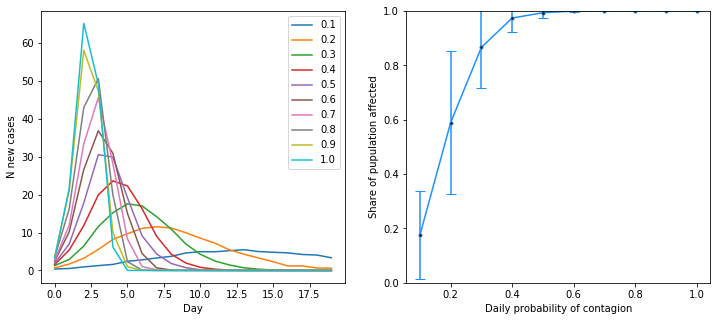

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(121)
for iprob in range(N_PROB_STEPS):
    plt.plot(np.mean(history[:, (N_TRIALS*iprob):(N_TRIALS*(iprob+1))],axis=1), label=prob[iprob]);
plt.xlabel('Day');
plt.ylabel('N new cases');
plt.legend(loc='upper right');

plt.subplot(122)
plt.plot(prob, np.average(total_infected, axis=0)/N_NODES, '-', color='dodgerblue');
plt.errorbar(prob, np.average(total_infected, axis=0)/N_NODES, 
             yerr=np.std(total_infected, axis=0)/N_NODES, fmt='.', capsize=5,
             ecolor='dodgerblue', markerfacecolor='k');
plt.xlabel('Daily probability of contagion');
plt.ylabel('Share of pupulation affected');
plt.ylim(0,1);

In [18]:
# Computational experiment
N_STEPS = 20
N_NODES = 100
PROB = 0.2      # Propagation probability: no longer a constant!
N_PROB_STEPS = 10  # Prob will take this many values, in equal steps, from 1/n to 1 (inclusive).
INFECT_PERIOD = 10
N_TRIALS = 100      # For each combination of parameters

history = np.zeros(shape=(N_STEPS, N_TRIALS*N_PROB_STEPS))
total_infected = np.zeros(shape=(N_TRIALS, N_PROB_STEPS))
infect_period = np.zeros(INFECT_PERIOD)
for iperiod in range(INFECT_PERIOD):
    infect_period[iperiod] = iperiod+1
    for itrial in range(N_TRIALS):
        g = barabasi(N_NODES)
        history[:, itrial+iperiod*N_TRIALS] = pandemic(g, prob=PROB, 
                                                     nsteps=N_STEPS, infect_period=infect_period[iperiod])
        count_infected = 0
        for node, val in g.values.items():
            if val[0]=='immune' or val[0]=='infected':
                count_infected += 1
        total_infected[itrial, iperiod] = count_infected

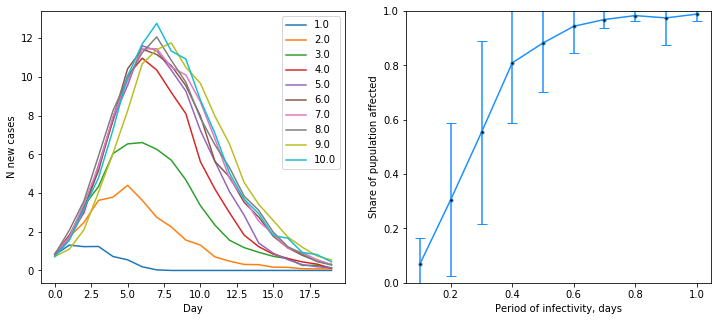

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(121)
for iperiod in range(N_PROB_STEPS):
    plt.plot(np.mean(history[:, (N_TRIALS*iperiod):(N_TRIALS*(iperiod+1))],axis=1), label=infect_period[iperiod]);
plt.xlabel('Day');
plt.ylabel('N new cases');
plt.legend(loc='upper right');

plt.subplot(122)
plt.plot(prob, np.average(total_infected, axis=0)/N_NODES, '-', color='dodgerblue');
plt.errorbar(prob, np.average(total_infected, axis=0)/N_NODES, 
             yerr=np.std(total_infected, axis=0)/N_NODES, fmt='.', capsize=5,
             ecolor='dodgerblue', markerfacecolor='k');
plt.xlabel('Period of infectivity, days');
plt.ylabel('Share of pupulation affected');
plt.ylim(0,1);